# 1- Download the dataset
* Forest Aerial Images : https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation

* Nguồn: https://www.kaggle.com/code/quadeer15sh/how-to-perform-semantic-segmentation-using-u-net

* Bộ dữ liệu này chứa 5108 hình ảnh trên không có kích thước 256x256
* 
Tệp meta_data.csv giữ thông tin về hình ảnh trên không và hình ảnh mặt nạ nhị phân tương ứng của chúng

* Bài toán phân đoạn các khu vực rừng

In [ ]:
#https://drive.google.com/file/d/1urX58pqlWC7rQ0kCP3E-d8I1Yjdkvi6M/view?usp=share_link
%%shell
gdown --q 1urX58pqlWC7rQ0kCP3E-d8I1Yjdkvi6M
echo 'download: done => file: forestsegm.zip'
rm -rf ./data/
mkdir data
unzip -q forestsegm.zip -d /content/data/
echo 'Data files in: /content/data/'


download: done => file: forestsegm.zip
Data files in: /content/data/


# 2- Import libraries

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model



# 3- Define Dataset and Loader

## 3.1- Dataset

In [ ]:
base_directory = '/content/data/Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

## 3.2- Loader
* Library for doing augmentation:
[https://albumentations.ai/docs/getting_started/mask_augmentation/](https://albumentations.ai/docs/getting_started/mask_augmentation/)

In [ ]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        '/content/data/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        '/content/data/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        '/content/data/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        '/content/data/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


# 4- Visualization

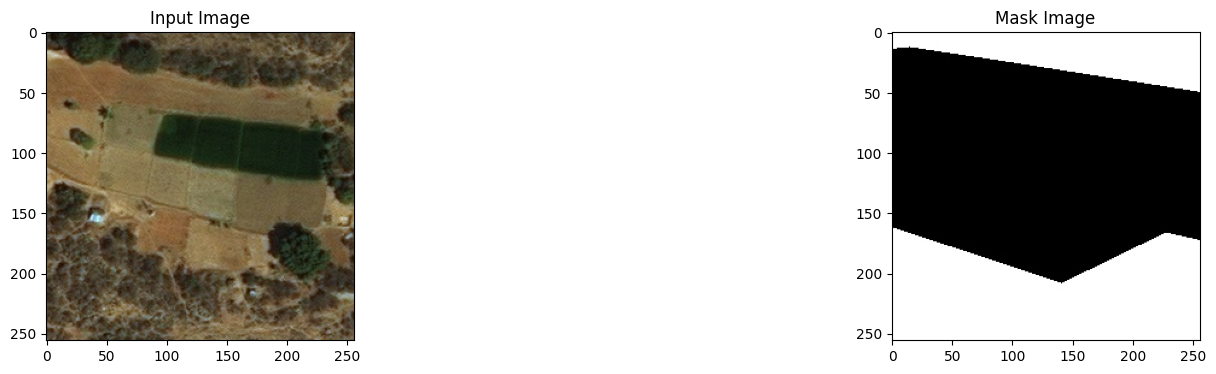

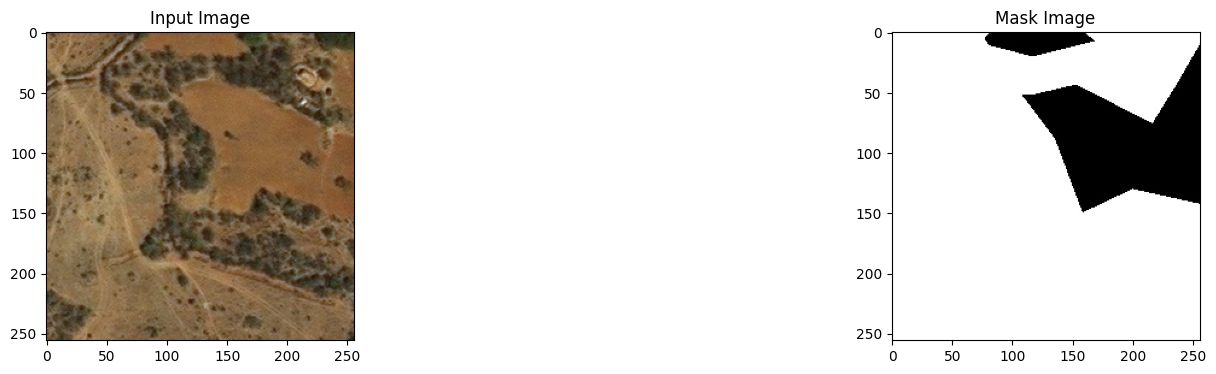

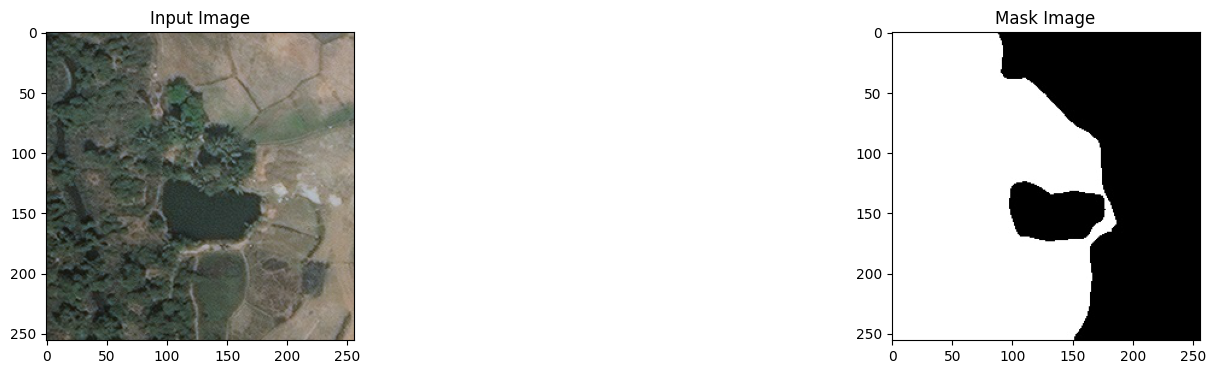

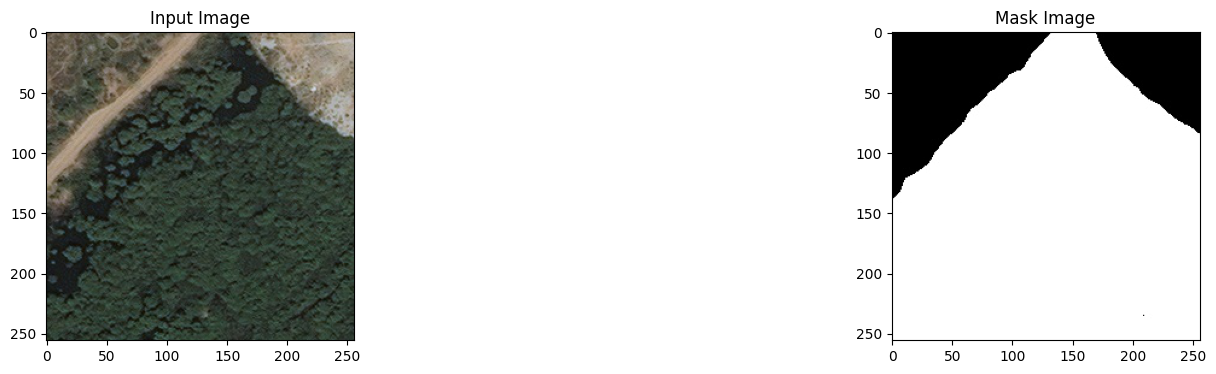

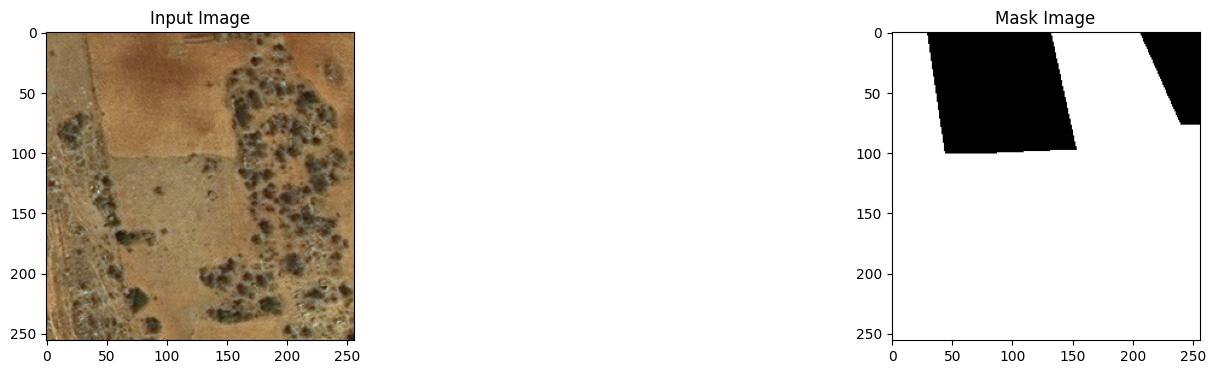

In [ ]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
      break

# 5- Custom Metrics

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

# 6- Model Training

In [ ]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

In [ ]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=5, callbacks=[earlystop, checkpoint])

In [ ]:
import seaborn as sns
sns.set_style('dark')

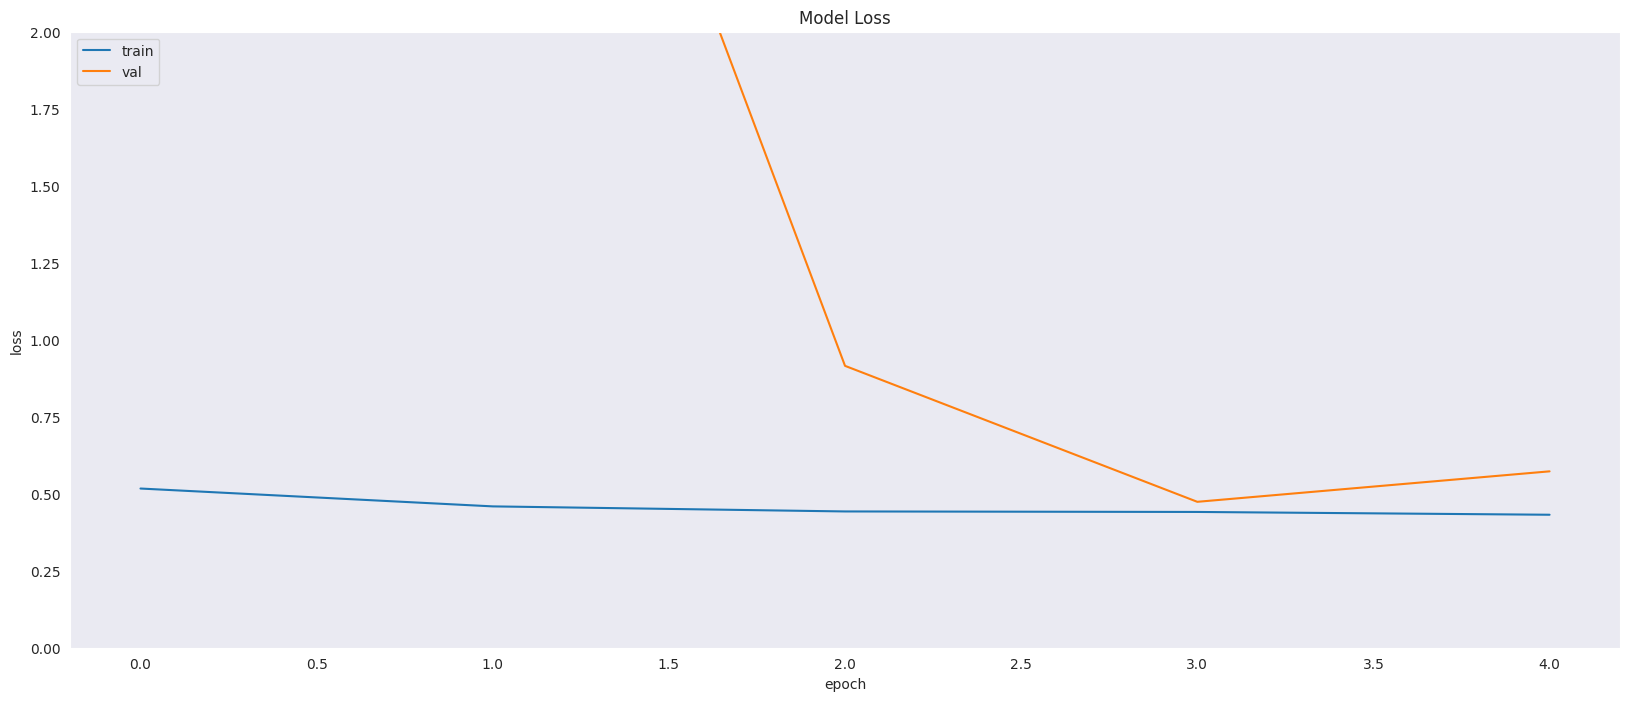

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 0s 471ms/step


# 7- Ground Truth Masks vs Predicted Masks

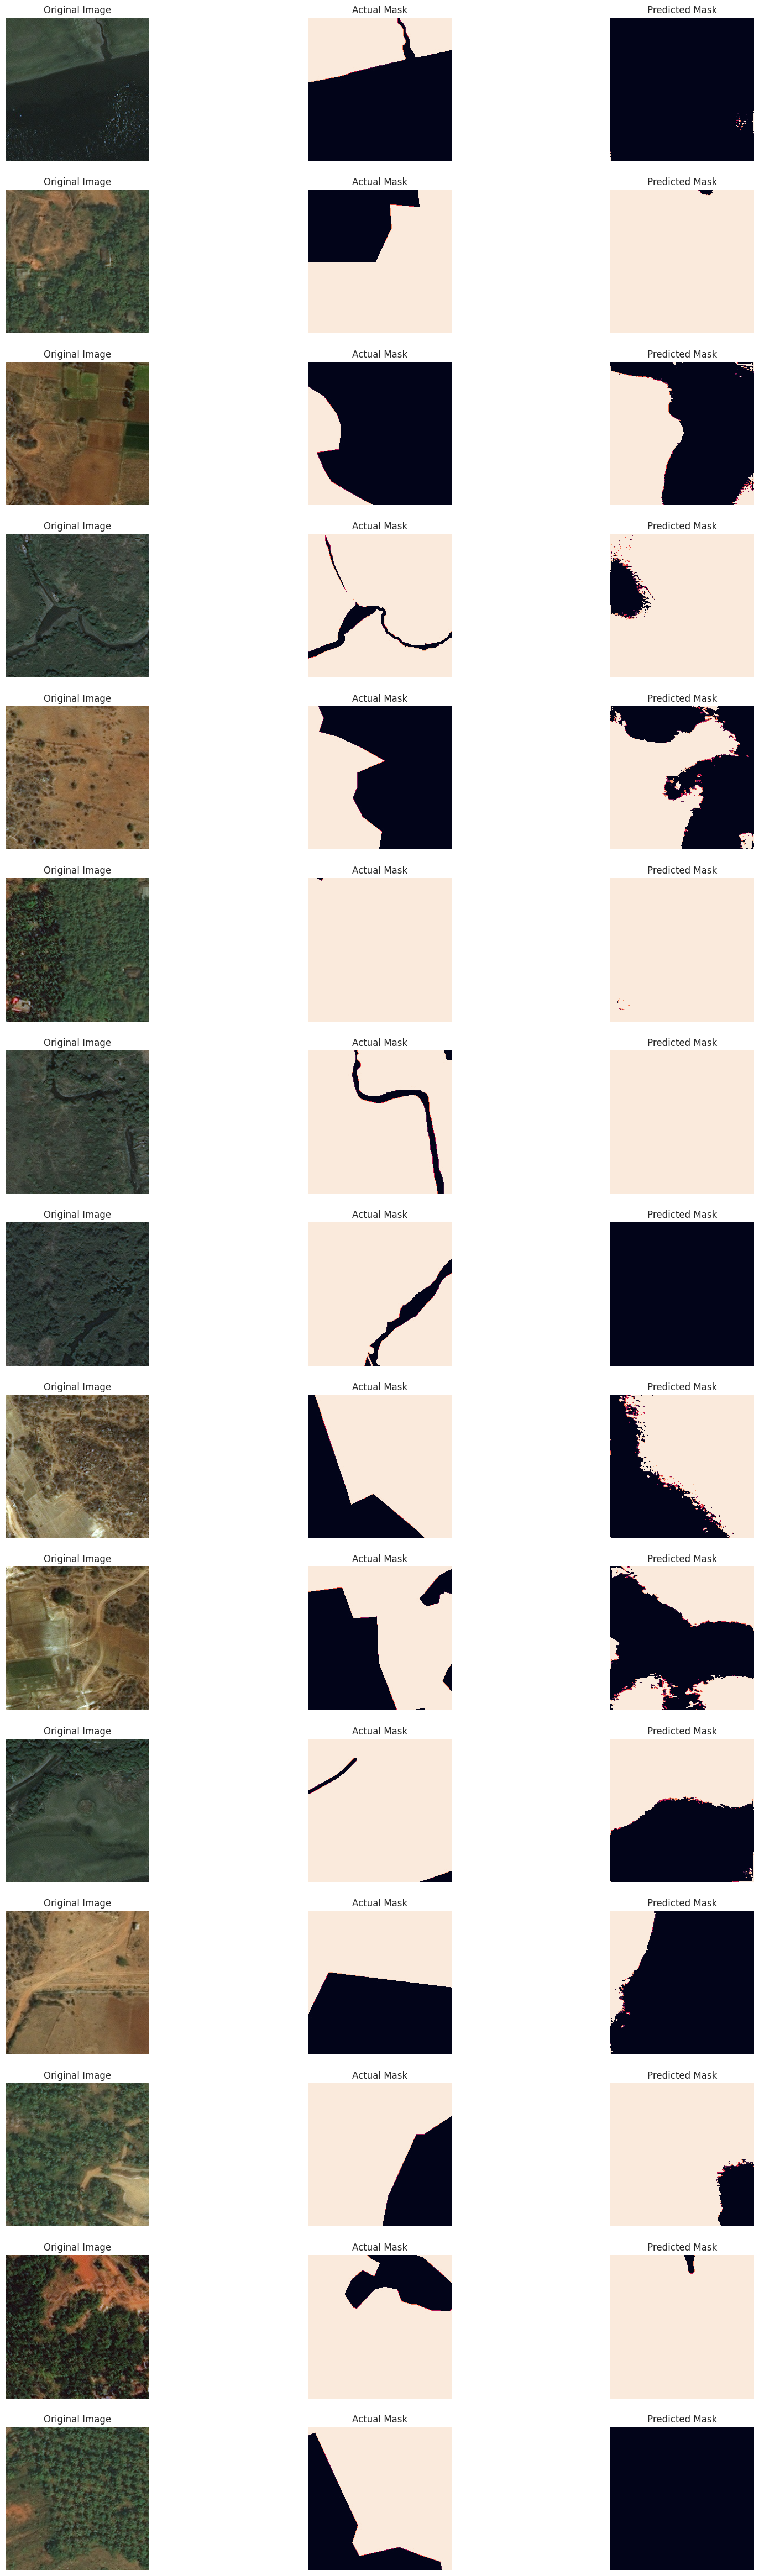

In [ ]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_masks[i])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

* Trong một số trường hợp segment mask không khớp với ground truth mask. Một số hình ảnh không được dán nhãn chính xác trong quá trình chuẩn bị dữ liệu